In [ ]:
import geopandas as gpd
import json
import rioxarray
import numpy as np
import pandas as pd
import rasterio
from rasterio.merge import merge
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from rasterio.io import MemoryFile

def get_key_slice(d, start, end):
    return list(d.keys())[start:end]

def get_mosaics_by_indices(indices, gdf, bands, date_slice_start, date_slice_end):
    data_files = []
    for idx in indices:
        tile_data_files = gdf.at[idx, 'date_files_mapping']
        for query_date in get_key_slice(tile_data_files, date_slice_start, date_slice_end):
            data_file = tile_data_files[query_date][0]
            with rioxarray.open_rasterio(data_file) as ds:
                date_str = ds.time
            date = np.datetime64(date_str, 'ns')
            data_files.append({'idx': idx, 'data_file': data_file, 'date': date})

    # Get unique dates within the date range
    dates = sorted(set(f['date'] for f in data_files))
    mosaics = []

    for date in dates:
        files_for_date = [f for f in data_files if f['date'] == date]
        rasterio_datasets = []

        # Open each file with nodata set to -1, and keep datasets open
        for f in files_for_date:
            src = rasterio.open(f['data_file'])
            profile = src.profile.copy()
            profile.update(nodata=-1)  # Set nodata to -1 in the profile

            # Copy the data into a memory file with updated nodata
            memfile = MemoryFile()
            temp_dataset = memfile.open(**profile)
            temp_dataset.write(src.read())
            rasterio_datasets.append(temp_dataset)  # Append the open dataset to the list

        # Merge the datasets while they are still open
        mosaic_array, out_trans = merge(rasterio_datasets, nodata=-1)

        # Metadata updates
        out_meta = rasterio_datasets[0].meta.copy()
        out_meta.update({
            "height": mosaic_array.shape[1],
            "width": mosaic_array.shape[2],
            "transform": out_trans,
            "nodata": -1  # Ensure no-data is specified in metadata
        })

        # Generate coordinate arrays
        transform = out_trans
        height, width = mosaic_array.shape[1], mosaic_array.shape[2]
        x_coords = np.arange(width) * transform.a + transform.c + transform.a / 2
        y_coords = np.arange(height) * transform.e + transform.f + transform.e / 2

        # Create xarray DataArray from the mosaic
        mosaic_da = xr.DataArray(
            mosaic_array,
            dims=('band', 'y', 'x'),
            coords={'band': bands, 'y': y_coords, 'x': x_coords},
            attrs={'transform': transform, 'crs': out_meta['crs']}
        )

        # Add time coordinate
        mosaic_da = mosaic_da.expand_dims({'time': [date]})
        mosaics.append(mosaic_da)

        # Properly close each MemoryFile after merge
        for dataset in rasterio_datasets:
            dataset.close()

    # Stack the mosaics over time
    stacked_mosaics = xr.concat(mosaics, dim='time')

    return stacked_mosaics

# Load data
gdf = gpd.read_file("../data/tiles_with_dates.geojson")
gdf['date_files_mapping'] = gdf['date_files_mapping'].apply(lambda x: json.loads(x))

county_boundary = gpd.read_file("../data/county_boundary.shp")

In [13]:
# Define your parameters
indices = [i for i in range(0, 500)]  # List of tile indices
bands = ['B02', 'B03', 'B04', 'B08']

# Call the function
stacked_mosaics = get_mosaics_by_indices(indices, gdf, bands, 0, 1) 

# Extract the month and year
date = pd.to_datetime(stacked_mosaics.coords['time'].values[0])
formatted_date = date.strftime("%B %Y")  # "April 2016"

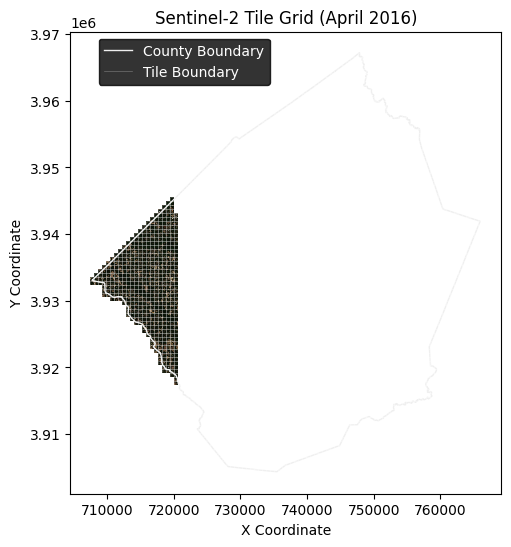

In [19]:
# Extract RGB bands from stacked_mosaics for visualization
rgb_array = stacked_mosaics.sel(band=['B04', 'B03', 'B02']).isel(time=0).values

# Increase brightness and contrast by applying a scaling factor
brightness_factor = 1.2  # Adjust brightness (values > 1 increase brightness, < 1 decrease)
contrast_factor = 1.3    # Adjust contrast (values > 1 increase contrast)

# Normalize the RGB array
rgb_array_normalized = rgb_array / rgb_array.max()  # Normalize data
# Mask the areas where values are NaN or -1 for brightness and contrast adjustments
rgb_array_mask = np.isnan(rgb_array_normalized) | (rgb_array_normalized < 0)
# Enhance brightness and contrast only on the valid data
brightness_factor = 1.3  # Adjust brightness (values > 1 increase brightness)
contrast_factor = 1.6    # Adjust contrast (values > 1 increase contrast)
rgb_array_brightened = np.clip(rgb_array_normalized * brightness_factor * contrast_factor, 0, 1)
# Apply the mask to set these areas to white (1, 1, 1)
rgb_array_brightened[rgb_array_mask] = 1  # Set NaN or negative areas to white

# Get x and y coordinate values from stacked_mosaics
x_coords = stacked_mosaics.x.values
y_coords = stacked_mosaics.y.values

# Plot the RGB image
fig, ax = plt.subplots(figsize=(6, 6))


# Display the RGB image with spatial extents
img = ax.imshow(
    rgb_array_brightened.transpose(1, 2, 0),
    extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
    interpolation="nearest"
)

# Plot the county boundary and tile boundaries
county_boundary.plot(ax=ax, facecolor='none', edgecolor='#efefef', linewidth=1.)
gdf.boundary.plot(ax=ax, edgecolor='#ffffff', linewidth=0.5, alpha=0.3)

# Create custom legend elements for County Boundary and Tile Boundary
legend_elements = [
    Line2D([0], [0], color='#efefef', lw=1., label='County Boundary'),
    Line2D([0], [0], color='#ffffff', lw=0.5, label='Tile Boundary', alpha=0.3),
]

# Add the legend for County Boundary and Tile Boundary with a black background and white text
legend = ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.05, 1), frameon=True)
legend.get_frame().set_facecolor('black')  # Set legend background color to black
legend.get_frame().set_edgecolor('black')  # Set legend border color to black

# Set the text color of the legend to white
for text in legend.get_texts():
    text.set_color("white")
    
# Title and labels
plt.title(f'Sentinel-2 Tile Grid ({formatted_date})')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()